In [39]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np
from numpy import cos, sin

from sympy import init_printing
init_printing()

%matplotlib inline
from sympy import *

# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

In [40]:
rad_mas = 206264806
rad_as  = 206264806/1000
as_mas  = 1000
AU_pc   = 4.84814e-6

In [41]:
def simple_function(R):
    Rx, Ry, Rz = R
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    return(d,delta,alpha)

In [42]:
def making_signal(R0, V0, times, t0=0, a_earth = 1):
    Rx, Ry, Rz = R0
    Vx, Vy, Vz = V0 
    
    rho = np.sqrt(Rx**2+Ry**2)
    
    d      = np.linalg.norm(R0, axis=0)
    delta  = np.arctan2(Rz, rho)
    alpha  = np.arctan2(Ry, Rx)
    
    sind, cosd, sina, cosa  = sin(delta), cos(delta), sin(alpha), cos(alpha)
    
    d_dot     =   Vx * cosa * cosd      +  Vy * sina * cosd     +  Vz * sind
    delta_dot = -(Vx * sind * cosa)/d   - (Vy * sina * sind)/d  + (Vz * cosd)/d
    alpha_dot = -(Vx * sina)/(d * cosd) + (Vy * cosa)/(d*cosd)
    
    T = times - t0
    
    proper_motion_term_dec = delta_dot*T
    proper_motion_term_ra  = alpha_dot*T
    
    parallax_term_dec = (a_earth/d)*sin(delta)*cos(2*np.pi*T-alpha)
    parallax_term_ra  = ((a_earth/(d*cos(delta)))*(sin(alpha)*cos(2*np.pi*T)-cos(alpha)*sin(2*np.pi*T)))
    
    signal_dec = proper_motion_term_dec + parallax_term_dec + delta 
    signal_ra  = proper_motion_term_ra  + parallax_term_ra + alpha
    
    return (proper_motion_term_dec, proper_motion_term_ra, 
            parallax_term_dec, parallax_term_ra,
            signal_dec, signal_ra)

In [43]:
def get_simulation(m_star = 1, vy_star = 2.498, vz_star=4.247, z_star = 50*206265, m_planet=0.0143188, inc=0, a_AU=0.6, e=0.2):
    sim_wp = rebound.Simulation()                                                              # create a simulation named sim_wp 

    sim_wp.units = ["msun","AU","year"]                                                        # setting units of sim_wpm

    sim_wp.add(m = 1)                                                                          # add the Sun as the central object 

    sim_wp.add(m = 3.0027e-6, a = 1, e = 0)                                                    # add Earth in a 1 AU circular orbit 
    
    sim_wp.add(x = 1.031e7, vy = vy_star, m = m_star, z = z_star, vz = vz_star)                # add a star 50 pc away with calculated velocity and set parameters

    sim_wp.add(m = m_planet, a = a_AU, e = e, primary = sim_wp.particles[2], inc = inc)        # add planet from figure 3.1 caption and have it orbit the star 
    
    com_particle  = sim_wp.calculate_com(first = 2,last = 4)
    ssbc_particle = sim_wp.calculate_com(first = 0,last = 2)
    
    sim = rebound.Simulation()                          # create a simulation named sim 

    sim.units = ["msun","AU","year"]                    # setting units of sim 

    sim.add(m = 1)                                      # add the Sun as the central object 

    sim.add(m = 3.0027e-6, a = 1, e = 0)                # add Earth in a 1 AU circular orbit 

    sim.add(com_particle)                               # add a particle equivaent to the star-planet barycentre
    
    return(sim_wp, sim)

In [44]:
s_, sim = get_simulation()

In [45]:
star_particle = sim.particles[2]
ssbc_particle = sim.calculate_com(first = 0,last = 2)

In [46]:
r_star = np.array(star_particle.xyz)
v_star = np.array(star_particle.vxyz)

In [47]:
r_ssbc = np.array(ssbc_particle.xyz)
v_ssbc = np.array(ssbc_particle.vxyz)

In [48]:
R0 = r_star - r_ssbc
V0 = v_star - v_ssbc

In [49]:
timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num = m)

In [50]:
function = making_signal(R0, V0, times)
proper_motion_term_dec, proper_motion_term_ra, parallax_term_dec, parallax_term_ra, signal_dec, signal_ra = function

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'could_extract_minus_sign'

In [51]:
_ = np.zeros(m)
alpha = np.zeros(m)
delta = np.zeros(m)
alpha_bc = np.zeros(m)
delta_bc = np.zeros(m)

_, sim = get_simulation()

star_particle = sim.particles[2]
ssbc_particle = sim.calculate_com(first = 0,last = 2)
earth_particle = sim.particles[1]

for i,t in enumerate(times):
    sim.integrate(t)
    r_star = np.array(star_particle.xyz)
    r_ssbc = np.array(ssbc_particle.xyz)
    r_earth = np.array(earth_particle.xyz)
    
    R = r_star - r_earth
    
    R_bc = r_star - r_ssbc
    
    _, delta_bc[i], alpha_bc[i] = simple_function(R_bc)
    
    _, delta[i], alpha[i] = simple_function(R)
    
    r_star - r_earth - (r_star - r_ssbc) = r_ssbc-r_earth

SyntaxError: cannot assign to operator (627511487.py, line 27)

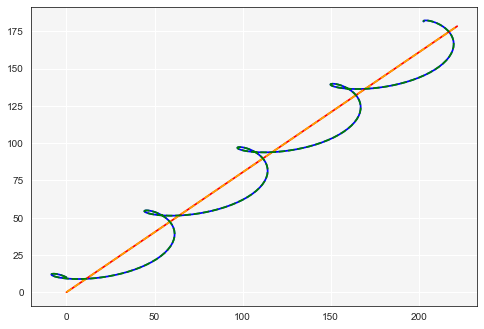

In [52]:
plt.plot((alpha-alpha_bc[0])*rad_mas,(delta-delta_bc[0])*rad_mas, color='blue') 

plt.plot((alpha_bc-alpha_bc[0])*rad_mas,(delta_bc-delta_bc[0])*rad_mas, color='red')

plt.plot(proper_motion_term_ra*rad_mas, proper_motion_term_dec*rad_mas, color='orange', ls='--')

predicted_x = parallax_term_ra+proper_motion_term_ra
predicted_y = parallax_term_dec+proper_motion_term_dec

plt.plot(predicted_x*rad_mas, predicted_y*rad_mas, color='green', ls='--')